Haven't uploaded to git yet

In [2]:
!pip install bio

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Module, Linear, ReLU, Sequential, Conv2d, Conv1d, MaxPool1d, MaxPool2d, BatchNorm1d, BatchNorm2d, Dropout
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder, normalize
#from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
train_data_path = "drive/My Drive/CS582/topic1-data/BATF/BATF-train-sequence.fa"
test_data_path = "drive/My Drive/CS582/topic1-data/BATF/BATF-test-sequence.fa"
train_label_path = "drive/My Drive/CS582/topic1-data/BATF/BATF-train.bed"
test_label_path = "drive/My Drive/CS582/topic1-data/BATF/BATF-train.bed"

In [6]:
def one_hot_encoder(sequence):
   #label_encoder = LabelEncoder()
   #label_encoder.fit(np.array(['A','C','G','T','Z']))
   #int_encoded = label_encoder.transform(seq_string)
   encoder = OneHotEncoder(sparse=False, dtype=int)
   #int_encoded = int_encoded.reshape(len(int_encoded), 1)
   encoder.fit([['A'], ['T'], ['C'], ['G']])
   onehot_encoded = encoder.transform(sequence)
   return onehot_encoded

In [24]:
train_data = [np.array(list(record.seq.__str__().upper())).reshape(-1, 1) for record in SeqIO.parse(train_data_path, "fasta")]
train_data = np.array([one_hot_encoder(data) for data in train_data]).astype('float32')
old_train_shape = train_data.shape
train_data = torch.as_tensor(train_data.reshape(old_train_shape[0], 1, old_train_shape[1], old_train_shape[2]))
print(train_data.shape)
"""
print(train_data[0])
print(train_data.shape)
type(train_data)
"""
test_data = [np.array(list(record.seq.__str__().upper())).reshape(-1, 1) for record in SeqIO.parse(test_data_path, "fasta")]
test_data = np.array([one_hot_encoder(data) for data in test_data]).astype('float32')
#print(test_data.shape)
old_test_shape = test_data.shape
test_data = torch.as_tensor(test_data.reshape(old_test_shape[0], 1, old_test_shape[1], old_test_shape[2]))
print(test_data.shape)

torch.Size([1000, 1, 501, 4])
torch.Size([400, 1, 501, 4])


In [23]:
train_label = pd.read_csv(train_label_path, sep='\t', header=None).drop(labels=0, axis=1)
train_label.columns = ['targets']
train_label = torch.tensor(train_label['targets'].values).float()
print(train_label.shape)


test_label = pd.read_csv(test_label_path, sep='\t', header=None).drop(labels=0, axis=1)
test_label.columns = ['targets']
test_label = torch.tensor(test_label['targets'].values).float()
print(test_label.shape)

torch.Size([1000])
torch.Size([1000])


In [31]:
class CNN(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=10, kernel_size=(20, 4), stride=1)
        self.conv2 = Conv1d(in_channels=10, out_channels=20, kernel_size=14, stride=1)
        self.conv3 = Conv1d(in_channels=20, out_channels=30, kernel_size=10, stride=1)

        self.fc1 = Linear(in_features=30*105, out_features=1500)
        self.fc2 = Linear(in_features=1500, out_features=250)
        self.out = Linear(in_features=250, out_features=1)
        """
        self.cnn_layers1 = Sequential(
            ,
            BatchNorm2d(10),
            ReLU(inplace=True)
        )
        self.cnn_layers2 = Sequential(
            MaxPool1d(kernel_size=2, stride=2),
            ,
            BatchNorm1d(20),
            ReLU(inplace=True),
            MaxPool1d(kernel_size=2, stride=2),
            ,
            BatchNorm1d(20)
        )

        self.linear_layers = Sequential(
            ,
            BatchNorm1d(num_features=3000),
            ReLU(inplace=True),
            ,
            BatchNorm1d(num_features=750),
            ReLU(inplace=True)
        )
        """
    def forward(self, x):
        x = F.relu((self.conv1(x)).squeeze())
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2, 2)
        x = F.relu(self.conv3(x))

        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x  


Anything else needed after last layer's ReLU?
Play with #layers, kernel sizes, batchnorm (yes/no), pooling kernel sizes, linear layer count, percptron count

In [35]:
model = CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Any better choice of loss function?

In [38]:
epochs = 100
train_mse = []
for epoch in range (epochs):
    #print("Epoch " + str(epoch))
    epoch_mse = 0
    batch_size= 100
    batch_start_index = 0
    train_set_size = len(train_data)
    #train_set_size = 100
    batch_no = 1
    while(batch_start_index < train_set_size):
        
        batch_end_index = min(train_set_size, batch_start_index + batch_size)
        train_data_batch = train_data[batch_start_index:batch_end_index]
        train_label_batch = train_label[batch_start_index:batch_end_index]
        batch_start_index = batch_end_index
        train_pred = model(train_data_batch)
        batch_mse = criterion(train_pred, train_label_batch)
        #print("batch no: " + str(batch_no) + " batch_mse: " + str(batch_mse.item()))
        batch_no += 1
        epoch_mse += batch_mse
        optimizer.zero_grad()
        batch_mse.backward()
        optimizer.step()
    print("epoch: " + str(epoch) + " epoch_mse: " + str(epoch_mse.item()))
    train_mse.append(epoch_mse)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 epoch_mse: 1.4749794006347656
epoch: 1 epoch_mse: 1.2056770324707031
epoch: 2 epoch_mse: 1.2974848747253418
epoch: 3 epoch_mse: 1.3375959396362305
epoch: 4 epoch_mse: 1.3032256364822388
epoch: 5 epoch_mse: 1.2835805416107178
epoch: 6 epoch_mse: 1.2955304384231567
epoch: 7 epoch_mse: 1.29873788356781
epoch: 8 epoch_mse: 1.294608235359192
epoch: 9 epoch_mse: 1.2910884618759155
epoch: 10 epoch_mse: 1.2913658618927002
epoch: 11 epoch_mse: 1.2914879322052002
epoch: 12 epoch_mse: 1.290453314781189
epoch: 13 epoch_mse: 1.2893799543380737
epoch: 14 epoch_mse: 1.288831114768982
epoch: 15 epoch_mse: 1.2882754802703857
epoch: 16 epoch_mse: 1.2877463102340698
epoch: 17 epoch_mse: 1.2870155572891235
epoch: 18 epoch_mse: 1.2865194082260132
epoch: 19 epoch_mse: 1.285852313041687
epoch: 20 epoch_mse: 1.2851918935775757
epoch: 21 epoch_mse: 1.2849041223526
epoch: 22 epoch_mse: 1.2827863693237305
epoch: 23 epoch_mse: 1.2891066074371338
epoch: 24 epoch_mse: 1.2838115692138672
epoch: 25 epoch_mse

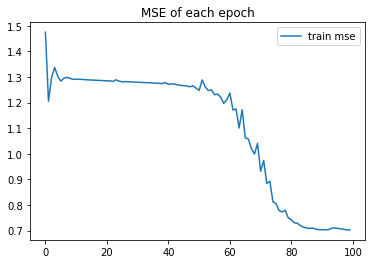

In [39]:
plt.plot(train_mse, label='train mse')
plt.title('MSE of each epoch')
plt.legend();

Issue: How to combine MSE of multiple batches? Sum or something else?
If we want to take RMSE, sqrt per batch then sum over batches or first sum over batches then sqrt per epoch?
Is batch size = 250 okay...

In [ ]:
with torch.no_grad():
    test_pred = model(test_data)
    test_mse = criterion(test_pred, test_label))

The next codes are trial stuff, pwm calculation etc.

```
# This is formatted as code
```



In [ ]:
conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(20, 4), stride=1)

out = torch.squeeze(conv1(train_data))
print(out.shape)
conv2 = nn.Conv1d(in_channels=10, out_channels=20, kernel_size=15, stride=1)
out = conv2(out)
print(out.shape)

torch.Size([1000, 10, 482])
torch.Size([1000, 20, 468])


torch.Size([1000, 3, 482, 1])


In [ ]:
batch_size = 2
channels = 1
height = 3
length = 10
kernel_size = (height, 5)

x = torch.randn(batch_size, channels, height, length)

print(x.shape)

conv = nn.Conv2d(
    in_channels=1,
    out_channels=6,
    kernel_size=kernel_size,
    stride=1,
    padding=(0, 2)
)

print(conv.weight.shape)
output = conv(x)
print(output.shape)

torch.Size([2, 1, 3, 10])
torch.Size([6, 1, 3, 5])
torch.Size([2, 6, 1, 10])


In [ ]:
for p in pwm:
  print(p.shape)

(14, 4)
(17, 4)
(15, 4)
(8, 4)
(8, 4)
(15, 4)
(18, 4)
(10, 4)


In [ ]:
pwm_files = ['BATF_FB_1', 'BATF_GM12878_1', 'BATF_GM12878_2', 'BATF_GM12878_3', 'BATF_GM12878_4', 'BATF_GM12878_5', 'BATF_HOCO_A', 'BATF_HOCO_S']
pwm = [pd.read_csv("drive/My Drive/CS582/topic1-data/BATF/" + pwm_file + ".wtmx", names = ['A', 'C', 'G', 'T'], sep="\t", header=None, skiprows=1, skipfooter=1) for pwm_file in pwm_files]
kernel_size = [p.shape for p in pwm]
print(kernel_size)
"""
site_lengths = np.array([p.shape[0] for p in pwm])
print(site_lengths)
append_size = max(site_lengths) - site_lengths
append_size_up = append_size // 2
append_size_down = append_size - append_size_up
print(append_size)
print(append_size_up)
print(append_size_down)
depth = len(pwm_files)
for i in range(depth):
    pwm[i] = normalize(pwm[i], norm="l1")
    pwm[i] = np.pad(pwm[i], ((append_size_up[i], append_size_down[i]), (0, 0)), 'constant', constant_values=(0.25, 0.25))
    print(pwm[i].shape)
    print(pwm[i])
"""

In [ ]:
pwm1 = pd.read_csv("drive/My Drive/CS582/topic1-data/BATF/BATF_FB_1.wtmx", sep="\t", header=None, skiprows=1, skipfooter=1)
pwm1.columns  =['A', 'C', 'G', 'T']

pwm2 = pd.read_csv("drive/My Drive/CS582/topic1-data/BATF/BATF_GM12878_1.wtmx", sep="\t", header=None, skiprows=1, skipfooter=1)
pwm2.columns  =['A', 'C', 'G', 'T']

pwm3 = pd.read_csv("drive/My Drive/CS582/topic1-data/BATF/BATF_GM12878_2.wtmx", sep="\t", header=None, skiprows=1, skipfooter=1)
pwm3.columns  =['A', 'C', 'G', 'T']

pwm4 = pd.read_csv("drive/My Drive/CS582/topic1-data/BATF/BATF_GM12878_3.wtmx", sep="\t", header=None, skiprows=1, skipfooter=1)
pwm4.columns  =['A', 'C', 'G', 'T']

pwm5 = pd.read_csv("drive/My Drive/CS582/topic1-data/BATF/BATF_GM12878_4.wtmx", sep="\t", header=None, skiprows=1, skipfooter=1)
pwm5.columns  =['A', 'C', 'G', 'T']

pwm6 = pd.read_csv("drive/My Drive/CS582/topic1-data/BATF/BATF_GM12878_5.wtmx", sep="\t", header=None, skiprows=1, skipfooter=1)
pwm6.columns  =['A', 'C', 'G', 'T']

pwm7 = pd.read_csv("drive/My Drive/CS582/topic1-data/BATF/BATF_HOCO_A.wtmx", sep="\t", header=None, skiprows=1, skipfooter=1)
pwm7.columns  =['A', 'C', 'G', 'T']

pwm8 = pd.read_csv("drive/My Drive/CS582/topic1-data/BATF/BATF_HOCO_S.wtmx", sep="\t", header=None, skiprows=1, skipfooter=1)
pwm8.columns  =['A', 'C', 'G', 'T']



In [ ]:
print(pwm1.shape)
print(pwm2.shape)
print(pwm3.shape)
print(pwm4.shape)
print(pwm5.shape)
print(pwm6.shape)
print(pwm7.shape)
print(pwm8.shape)

(14, 4)
(17, 4)
(15, 4)
(8, 4)
(8, 4)
(15, 4)
(18, 4)
(10, 4)


In [ ]:
np.pad(pwm1, )

In [ ]:
!pip install fasta-one-hot-encoder

In [ ]:
!pip uninstall fasta_one_hot_encoder

In [ ]:
from fasta_one_hot_encoder import FastaOneHotEncoder

In [ ]:
encoder = FastaOneHotEncoder(
    nucleotides = "ACTG",
    lower = False,
    sparse = False,
    handle_unknown="ignore"
)
encoder.transform_to_df(train_path, verbose=True).to_csv("train.csv")

In [ ]:
train_data = pd.read_csv('train.csv')

In [ ]:
train_data

In [ ]:
train_data.shape